In [1]:
import os
import re
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from collections import Counter
from tensorflow.keras.saving import register_keras_serializable

## RNNBertBasedModel

In [2]:
@register_keras_serializable()
class RNNBertBasedModel(tf.keras.Model):
    def __init__(self, bert_model_name="bert-base-uncased", rnn_hidden_size=256, num_classes=5):
        super(RNNBertBasedModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.rnn = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(rnn_hidden_size, return_sequences=False)
        )
        self.fc = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        input_ids, attention_mask = inputs
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        rnn_output = self.rnn(bert_output.last_hidden_state)
        logits = self.fc(rnn_output)
        return logits

## Function to Parse Tree Structure

In [3]:
def parse_tree(line):
    """
    Parses a single line of the SST-2 tree structure to extract the root label and flattened sentence.
    """
    match = re.match(r"\((\d) (.*)\)", line)
    if not match:
        return None, None
    root_label = int(match.group(1))
    sentence = re.sub(r"\(\d\s", "", match.group(2)).replace(")", "").strip()
    return root_label, sentence

## Data Loading and Preprocessing

In [4]:
def load_and_preprocess_data(file_path):
    """
    Loads and preprocesses SST-2 data by parsing tree structures to extract labels and sentences.
    """
    labels = []
    sentences = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            label, sentence = parse_tree(line.strip())
            if label is not None and sentence:
                labels.append(label)
                sentences.append(sentence)
    return labels, sentences

## Model Training and Evaluation

In [5]:
def main():
    # File paths
    train_file = "train.txt"
    dev_file = "dev.txt"

    # Load and preprocess data
    train_labels, train_sentences = load_and_preprocess_data(train_file)
    val_labels, val_sentences = load_and_preprocess_data(dev_file)

    # --- Dataset Reduction ---
    num_samples_per_class = int(len(train_labels) * 0.15) // (len(set(train_labels)))

    reduced_train_sentences = []
    reduced_train_labels = []
    label_counts = Counter()

    for sentence, label in zip(train_sentences, train_labels):
        if label_counts[label] < num_samples_per_class:
            reduced_train_sentences.append(sentence)
            reduced_train_labels.append(label)
            label_counts[label] += 1

    train_sentences = reduced_train_sentences
    train_labels = reduced_train_labels
    # --- End of Dataset Reduction ---


    # Analyze data (after reduction)
    label_distribution = Counter(train_labels)
    print("Training label distribution (after reduction):", label_distribution)

    # Tokenizer setup
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    max_length = 50

    # Tokenize data (using reduced data)
    train_encodings = tokenizer(train_sentences, truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    val_encodings = tokenizer(val_sentences, truncation=True, padding=True, max_length=max_length, return_tensors="tf")

    # Create TensorFlow datasets (using reduced data)
    train_dataset = tf.data.Dataset.from_tensor_slices(((train_encodings["input_ids"], train_encodings["attention_mask"]), train_labels))
    val_dataset = tf.data.Dataset.from_tensor_slices(((val_encodings["input_ids"], val_encodings["attention_mask"]), val_labels))

    train_dataset = train_dataset.shuffle(len(train_sentences)).batch(16).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)
    model = RNNBertBasedModel()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks for training
    # Callbacks for training
    checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, mode="max") # Changed file extension to .keras
    early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, mode="max", restore_best_weights=True)
    # Train model
    model.fit(train_dataset,
              validation_data=val_dataset,
              epochs=5,
              callbacks=[checkpoint, early_stopping])
    return model # Fixed indentation to align with the function body

## Execute Main Training Function and Save Model

In [6]:
if __name__ == "__main__":
    trained_model = main() # Assign the returned model to a variable
# %%
trained_model.save("final_trained_model.keras")

Training label distribution (after reduction): Counter({3: 256, 4: 256, 2: 256, 1: 256, 0: 256})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 506s 6s/step - accuracy: 0.3183 - loss: 1.6180 - val_accuracy: 0.3560 - val_loss: 1.3388
Epoch 2/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 536s 7s/step - accuracy: 0.5832 - loss: 1.0583 - val_accuracy: 0.4124 - val_loss: 1.3338
Epoch 3/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 508s 6s/step - accuracy: 0.6929 - loss: 0.8030 - val_accuracy: 0.3751 - val_loss: 1.4973
Epoch 4/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 503s 6s/step - accuracy: 0.8098 - loss: 0.5463 - val_accuracy: 0.3778 - val_loss: 1.7012
Epoch 5/5
80/80 ━━━━━━━━━━━━━━━━━━━━ 483s 6s/step - accuracy: 0.8848 - loss: 0.3323 - val_accuracy: 0.3833 - val_loss: 1.8353


In [7]:
!pip install transformers tensorflow

In [8]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import classification_report
import numpy as np
import re
import os
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class RNNBertBasedModel(tf.keras.Model):
    def __init__(self, bert_model_name="bert-base-uncased", rnn_hidden_size=256, num_classes=5):
        super(RNNBertBasedModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.rnn = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(rnn_hidden_size, return_sequences=False)
        )
        self.fc = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        input_ids, attention_mask = inputs
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        rnn_output = self.rnn(bert_output.last_hidden_state)
        logits = self.fc(rnn_output)
        return logits

    # Add get_config and from_config methods
    # Add get_config and from_config methods
    def get_config(self):
        config = super(RNNBertBasedModel, self).get_config()
        config.update({
            "bert_model_name": "bert-base-uncased",
            "rnn_hidden_size": 256,
            "num_classes": 5
        })
        return config

    @classmethod
    def from_config(cls, config):
        # The config dictionary is directly passed, not nested under 'config'
        # Remove unexpected 'trainable' argument from config, if present
        config.pop('trainable', None)
        # Remove unexpected 'dtype' argument from config, if present
        config.pop('dtype', None)
        return cls(**config)  # Directly use the config dictionary
def parse_tree(line):
    """
    Parses a single line of the SST-2 tree structure to extract the root label and flattened sentence.
    """
    match = re.match(r"\((\d) (.*)\)", line)
    if not match:
        return None, None
    root_label = int(match.group(1))
    sentence = re.sub(r"\(\d\s", "", match.group(2)).replace(")", "").strip()
    return root_label, sentence

def load_and_preprocess_test_data(file_path):
    """
    Loads and preprocesses SST-2 test data by parsing tree structures to extract labels and sentences.
    """
    labels, sentences = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            label, sentence = parse_tree(line.strip())
            if label is not None and sentence:
                labels.append(label)
                sentences.append(sentence)
    return labels, sentences

def evaluate_model(test_file, model_path, max_length=50):
    # Load the test data
    test_labels, test_sentences = load_and_preprocess_test_data(test_file)

    # Tokenizer setup
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    test_encodings = tokenizer(test_sentences, truncation=True, padding=True, max_length=max_length, return_tensors="tf")

    # Create TensorFlow dataset
    test_dataset = tf.data.Dataset.from_tensor_slices(((test_encodings["input_ids"], test_encodings["attention_mask"]), test_labels))
    test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

    # Load the saved model
    model = tf.keras.models.load_model(model_path, custom_objects={'RNNBertBasedModel': RNNBertBasedModel})

    # Evaluate the model
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)

    # Generate classification report
    print("Classification Report:")
    print(classification_report(test_labels, predicted_labels, digits=4))

# Example Usage
if __name__ == "__main__":
    test_file = "test.txt"  # Path to your test dataset
    # Get the current working directory
    current_dir = os.getcwd()
    # Construct the path to the model file in the current directory
    model_path = os.path.join(current_dir, "final_trained_model.keras")
    evaluate_model(test_file, model_path)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

139/139 ━━━━━━━━━━━━━━━━━━━━ 444s 3s/step
Classification Report:
              precision    recall  f1-score   support

           0     0.1304    0.0538    0.0761       279
           1     0.3113    0.4234    0.3588       633
           2     0.1969    0.3265    0.2456       389
           3     0.2586    0.2216    0.2386       510
           4     0.3224    0.1228    0.1779       399

    accuracy                         0.2588      2210
   macro avg     0.2439    0.2296    0.2194      2210
weighted avg     0.2582    0.2588    0.2428      2210



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

139/139 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step
Classification Report:
               precision    recall  f1-score   support

Very Negative     0.1130    0.0466    0.0660       279
     Negative     0.3537    0.0458    0.0811       633
      Neutral     0.1818    0.0103    0.0195       389
     Positive     0.2458    0.0569    0.0924       510
Very Positive     0.1858    0.8722    0.3063       399

     accuracy                         0.1914      2210
    macro avg     0.2160    0.2063    0.1131      2210
 weighted avg     0.2378    0.1914    0.1116      2210



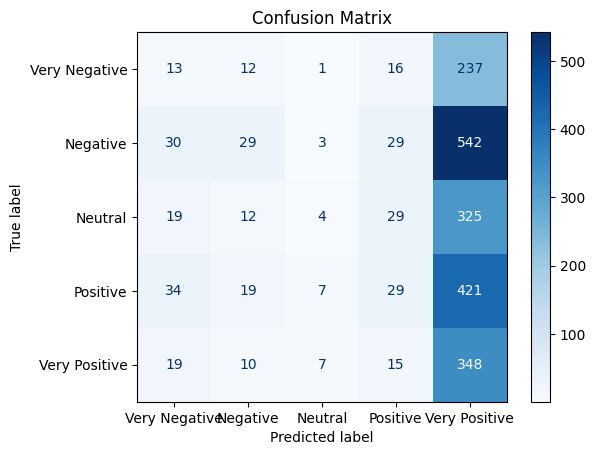

In [9]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from tensorflow.keras.saving import register_keras_serializable

# Register the custom model
@register_keras_serializable()
class RNNBertBasedModel(tf.keras.Model):
    def __init__(self, bert_model_name="bert-base-uncased", rnn_hidden_size=256, num_classes=5):
        super(RNNBertBasedModel, self).__init__()
        self.bert = TFBertModel.from_pretrained(bert_model_name)
        self.rnn = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(rnn_hidden_size, return_sequences=False)
        )
        self.fc = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        input_ids, attention_mask = inputs
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        rnn_output = self.rnn(bert_output.last_hidden_state)
        logits = self.fc(rnn_output)
        return logits

    def get_config(self):
        config = super(RNNBertBasedModel, self).get_config()
        config.update({
            "bert_model_name": "bert-base-uncased",
            "rnn_hidden_size": 256,
            "num_classes": 5
        })
        return config

    @classmethod
    def from_config(cls, config):
        config.pop('trainable', None)
        config.pop('dtype', None)
        return cls(**config)

# Helper function for test data parsing
def parse_tree(line):
    match = re.match(r"\((\d) (.*)\)", line)
    if not match:
        return None, None
    root_label = int(match.group(1))
    sentence = re.sub(r"\(\d\s", "", match.group(2)).replace(")", "").strip()
    return root_label, sentence

def load_and_preprocess_test_data(file_path):
    labels, sentences = [], []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            label, sentence = parse_tree(line.strip())
            if label is not None and sentence:
                labels.append(label)
                sentences.append(sentence)
    return labels, sentences

# Visualization Functions
def plot_confusion_matrix(y_true, y_pred, classes):
    """
    Plot a confusion matrix for the given true and predicted labels.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

def plot_cross_entropy_loss(history):
    """
    Plot training and validation cross-entropy loss over epochs.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title("Cross-Entropy Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(history):
    """
    Plot training and validation accuracy over epochs.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluation with Visualizations
def evaluate_model_with_visualizations(test_file, model_path, history=None, max_length=50, classes=None):
    # Load test data
    test_labels, test_sentences = load_and_preprocess_test_data(test_file)

    # Tokenize test data
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    test_encodings = tokenizer(test_sentences, truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    test_dataset = tf.data.Dataset.from_tensor_slices(((test_encodings["input_ids"], test_encodings["attention_mask"]), test_labels))
    test_dataset = test_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

    # Load the trained model
    model = tf.keras.models.load_model(model_path, custom_objects={'RNNBertBasedModel': RNNBertBasedModel})

    # Predict on the test dataset
    predictions = model.predict(test_dataset)
    predicted_labels = np.argmax(predictions, axis=1)

    # Classification report
    print("Classification Report:")
    print(classification_report(test_labels, predicted_labels, target_names=classes, digits=4))

    # Confusion matrix
    plot_confusion_matrix(test_labels, predicted_labels, classes)

    # Plot loss and accuracy if history is provided
    if history is not None:
        plot_cross_entropy_loss(history)
        plot_accuracy(history)

# Example Usage
if __name__ == "__main__":
    test_file = "test.txt"  # Path to the test dataset
    current_dir = os.getcwd()  # Get the current working directory
    model_path = os.path.join(current_dir, "final_trained_model.keras")  # Path to the saved model
    classes = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]

    # Assuming `history` is available from training
    # Replace `history` with the actual history object or None if unavailable
    history = None
    evaluate_model_with_visualizations(test_file, model_path, history=history, classes=classes)